In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
#tf.enable_v2_behavior()
# Import tensornetwork
import tensornetwork as tn
# Set the backend to tesorflow
# (default is numpy)
tn.set_default_backend("tensorflow")

In [4]:
class TNLayer(tf.keras.layers.Layer):

    def __init__(self):
        super(TNLayer, self).__init__()
        # Create the variables for the layer.
        self.a_var = tf.Variable(tf.random.normal(
                shape=(32, 32, 2), stddev=1.0/32.0),
                 name="a", trainable=True)
        self.b_var = tf.Variable(tf.random.normal(shape=(32, 32, 2), stddev=1.0/32.0),
                                 name="b", trainable=True)
        self.bias = tf.Variable(tf.zeros(shape=(32, 32)), name="bias", trainable=True)

    def call(self, inputs):
        # Define the contraction.
        # We break it out so we can parallelize a batch using
        # tf.vectorized_map (see below).
        def f(input_vec, a_var, b_var, bias_var):
            # Reshape to a matrix instead of a vector.
            input_vec = tf.reshape(input_vec, (32,32))

            # Now we create the network.
            a = tn.Node(a_var)
            b = tn.Node(b_var)
            x_node = tn.Node(input_vec)
            a[1] ^ x_node[0]
            b[1] ^ x_node[1]
            a[2] ^ b[2]

            # The TN should now look like this
            #   |     |
            #   a --- b
            #    \   /
            #      x

            # Now we begin the contraction.
            c = a @ x_node
            result = (c @ b).tensor

            # To make the code shorter, we also could've used Ncon.
            # The above few lines of code is the same as this:
            # result = tn.ncon([x, a_var, b_var], [[1, 2], [-1, 1, 3], [-2, 2, 3]])

            # Finally, add bias.
            return result + bias_var

        # To deal with a batch of items, we can use the tf.vectorized_map
        # function.
        # https://www.tensorflow.org/api_docs/python/tf/vectorized_map
        result = tf.vectorized_map(
        lambda vec: f(vec, self.a_var, self.b_var, self.bias), inputs)
        return tf.nn.relu(tf.reshape(result, (-1, 1024)))

In [5]:
Dense = tf.keras.layers.Dense
fc_model = tf.keras.Sequential(
    [
     tf.keras.Input(shape=(2,)),
     Dense(1024, activation=tf.nn.relu),
     Dense(1024, activation=tf.nn.relu),
     Dense(1, activation=None)])
fc_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              3072      
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1025      
Total params: 1,053,697
Trainable params: 1,053,697
Non-trainable params: 0
_________________________________________________________________


In [6]:
tn_model = tf.keras.Sequential(
    [
     tf.keras.Input(shape=(2,)),
     Dense(1024, activation=tf.nn.relu),
     # Here, we replace the dense layer with our MPS.
     TNLayer(),
     Dense(1, activation=None)])
tn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1024)              3072      
_________________________________________________________________
tn_layer (TNLayer)           (None, 1024)              5120      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 1025      
Total params: 9,217
Trainable params: 9,217
Non-trainable params: 0
_________________________________________________________________


In [7]:
X = np.concatenate([np.random.randn(20, 2) + np.array([3, 3]), 
             np.random.randn(20, 2) + np.array([-3, -3]), 
             np.random.randn(20, 2) + np.array([-3, 3]), 
             np.random.randn(20, 2) + np.array([3, -3]),])

Y = np.concatenate([np.ones((40)), -np.ones((40))])

In [9]:
X.shape

(80, 2)

In [11]:
tn_model.compile(optimizer="adam", loss="mean_squared_error")
tn_model.fit(X, Y, epochs=300, verbose=1)

Epoch 1/300


/home/ryunagai/.pyenv/versions/TFq_3.7/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


3/3 [==============================] - 0s 3ms/step - loss: 0.9811
Epoch 2/300
3/3 [==============================] - 0s 3ms/step - loss: 0.9218
Epoch 3/300
3/3 [==============================] - 0s 2ms/step - loss: 0.8693
Epoch 4/300
3/3 [==============================] - 0s 3ms/step - loss: 0.8145
Epoch 5/300
3/3 [==============================] - 0s 2ms/step - loss: 0.7483
Epoch 6/300
3/3 [==============================] - 0s 3ms/step - loss: 0.6705
Epoch 7/300
3/3 [==============================] - 0s 2ms/step - loss: 0.5762
Epoch 8/300
3/3 [==============================] - 0s 2ms/step - loss: 0.4709
Epoch 9/300
3/3 [==============================] - 0s 2ms/step - loss: 0.3577
Epoch 10/300
3/3 [==============================] - 0s 2ms/step - loss: 0.2420
Epoch 11/300
3/3 [==============================] - 0s 2ms/step - loss: 0.1466
Epoch 12/300
3/3 [==============================] - 0s 2ms/step - loss: 0.0848
Epoch 13/300
3/3 [==============================] - 0s 2ms/step - loss: 0

3/3 [==============================] - 0s 2ms/step - loss: 2.9178e-05
Epoch 203/300
3/3 [==============================] - 0s 3ms/step - loss: 2.1945e-05
Epoch 204/300
3/3 [==============================] - 0s 3ms/step - loss: 2.6467e-05
Epoch 205/300
3/3 [==============================] - 0s 2ms/step - loss: 4.8227e-05
Epoch 206/300
3/3 [==============================] - 0s 2ms/step - loss: 2.9354e-05
Epoch 207/300
3/3 [==============================] - 0s 3ms/step - loss: 2.6676e-05
Epoch 208/300
3/3 [==============================] - 0s 3ms/step - loss: 2.0342e-05
Epoch 209/300
3/3 [==============================] - 0s 3ms/step - loss: 1.3930e-05
Epoch 210/300
3/3 [==============================] - 0s 2ms/step - loss: 1.1197e-05
Epoch 211/300
3/3 [==============================] - 0s 3ms/step - loss: 8.0274e-06
Epoch 212/300
3/3 [==============================] - 0s 3ms/step - loss: 8.8576e-06
Epoch 213/300
3/3 [==============================] - 0s 2ms/step - loss: 8.8504e-06
Epoch 

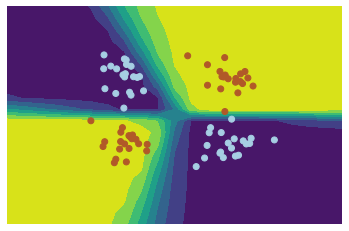

In [12]:
# Plotting code, feel free to ignore.
h = 1.0
x_min, x_max = X[:, 0].min() - 5, X[:, 0].max() + 5
y_min, y_max = X[:, 1].min() - 5, X[:, 1].max() + 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# here "model" is your model's prediction (classification) function
Z = tn_model.predict(np.c_[xx.ravel(), yy.ravel()]) 

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z)
plt.axis('off')

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired)